In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
import scipy
from skimage import color, exposure, measure, morphology
import segmentflow.segment as sf
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Run Segmentflow on the sample IDOX_EstaneNP

Loading images...
--> Images loaded as 3D array:  (1012, 630, 630)
Plotting images: [100, 450, 800]


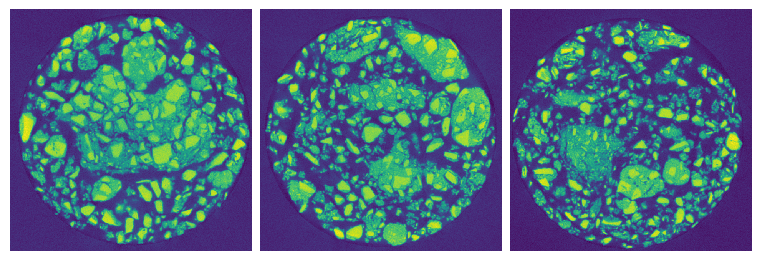

In [2]:
#-------------#
# Load images #
#-------------#
# row & col crop deterined in NB 14
slices = [100, 450, 800]
imgs = sf.load_images(
    r'../data/IDOX_EstaneNP/IDOX_EstaneNP_AHE',
    slice_crop=None,
    row_crop=[200, 830],
    col_crop=[190, 820],
    convert_to_float=True,
    file_suffix='.tiff'
)
fig, axes = sf.plot_imgs(
    imgs,
    # n_imgs=3,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

## Investigate raw data

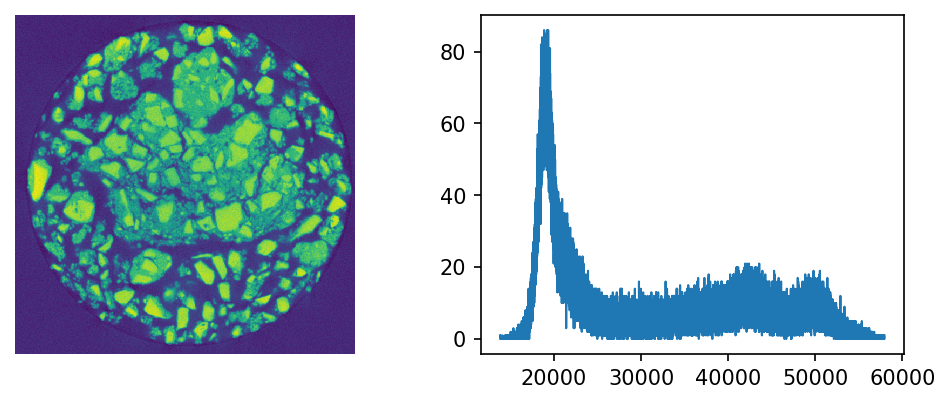

In [3]:
img = imgs[100, ...]
# Plot histogram
hist, hist_centers = exposure.histogram(img)
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
ax = axes.ravel()
ax[0].imshow(img, interpolation='nearest')
ax[0].axis('off')
ax[1].plot(hist_centers, hist, lw=1)
plt.show()

## Apply median filter

Preprocessing images...
--> Applying median filter...
--> Preprocessing complete
Plotting images: [100, 450, 800]


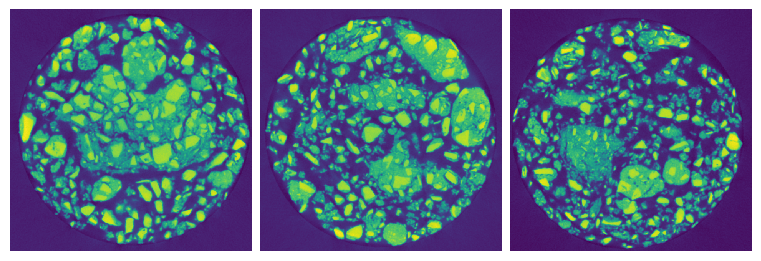

In [4]:
#---------------#
# Median filter #
#---------------#
imgs_med = sf.preprocess(
    imgs, median_filter=True,
    rescale_intensity_range=None
)
fig, axes = sf.plot_imgs(
    imgs_med,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)


## Multi-Otsu

In [5]:
#-----------------#
# Binarize images #
#-----------------#
run_this_cell = False
if run_this_cell:
    imgs_binarized, thresh_vals = sf.binarize_multiotsu(
        imgs_med,
        n_otsu_classes=3,
        downsample_image_factor=1,
        n_selected_thresholds=1,
    )
    print(thresh_vals)
    img = imgs_med[100, ...]
    thresh_high = 40400
    thresh_low = 27500
    # Plot histogram
    hist, hist_centers = exposure.histogram(imgs_med)
    fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
    ax = axes.ravel()
    ax[0].imshow(img, interpolation='nearest')
    ax[0].axis('off')
    ax[1].plot(hist_centers, hist, lw=1)
    ax[1].axvline(thresh_low, c='red')
    ax[1].axvline(thresh_high, c='red')
    # Plot isolated classes
    imgs_thresh = sf.isolate_classes(imgs, thresh_vals)
    fig, axes = sf.plot_imgs(
        imgs_thresh,
        slices=slices,
        print_slices=True,
        imgs_per_row=None,
        fig_w=7.5,
        dpi=100
    )
    plt.show()

## Local minima

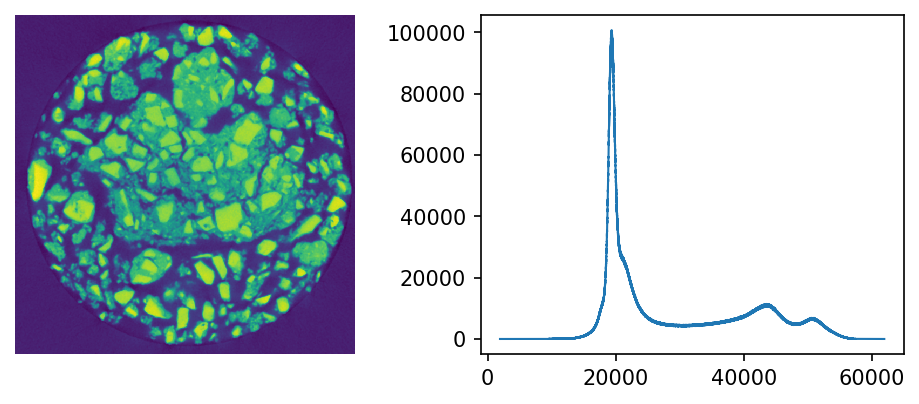

In [6]:
img = imgs_med[100, ...]
# Plot histogram
hist, hist_centers = exposure.histogram(imgs_med)
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
ax = axes.ravel()
ax[0].imshow(img, interpolation='nearest')
ax[0].axis('off')
ax[1].plot(hist_centers, hist, lw=1)
plt.show()

hist.shape=(60019,)
peaks.shape=(3,)
peaks=array([17433, 41625, 48975], dtype=int64)
mins.shape=(2,)
mins=array([10894, 28453], dtype=int64)
thresh_vals_by_min=array([28327, 45886], dtype=int64)


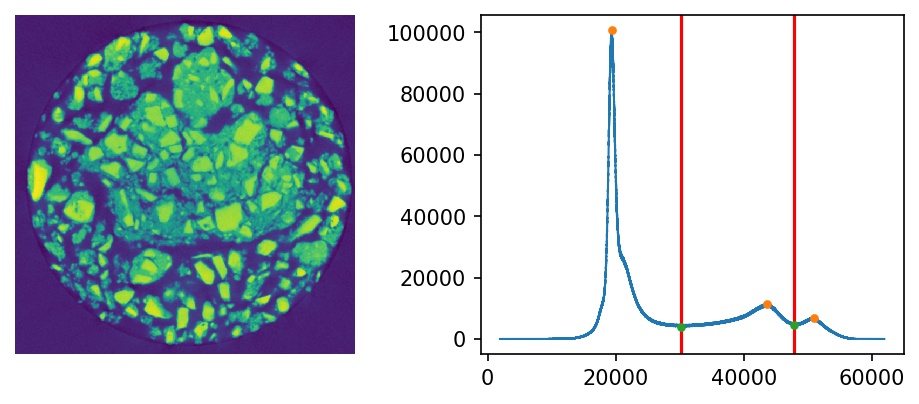

Plotting images: [100, 450, 800]


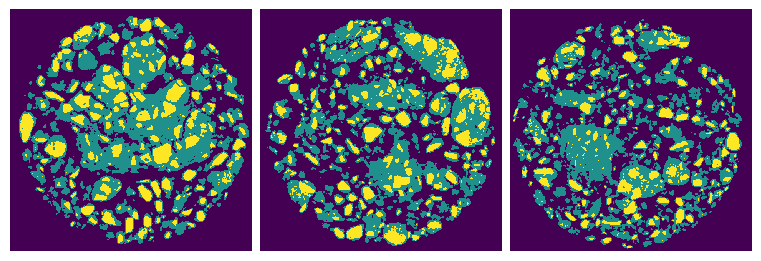

Plotting images: [100, 450, 800]


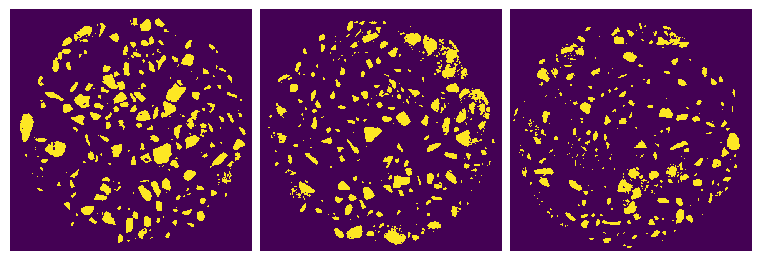

In [7]:
print(f'{hist.shape=}')
peaks, peak_props = scipy.signal.find_peaks(hist, width=100)
print(f'{peaks.shape=}')
print(f'{peaks=}')
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)
ax = axes.ravel()
ax[0].imshow(img, interpolation='nearest')
ax[0].axis('off')
ax[1].plot(hist_centers, hist, lw=1, zorder=0)
for i in peaks:
    ax[1].scatter(hist_centers[i], hist[i], s=10, c='C1', zorder=1)
signal_y = -hist[peaks[0]:peaks[-1]]
signal_x = hist_centers[peaks[0]:peaks[-1]]
mins, min_props = scipy.signal.find_peaks(signal_y, width=100)
print(f'{mins.shape=}')
print(f'{mins=}')
thresh_vals_by_min = peaks[0] + mins
print(f'{thresh_vals_by_min=}')
for i in mins:
    ax[1].scatter(signal_x[i], -signal_y[i], s=10, c='C2', zorder=1)
    ax[1].axvline(signal_x[i], c='red', zorder=0)
plt.show()
# Plot isolated classes
imgs_thresh = sf.isolate_classes(imgs_med, thresh_vals_by_min)
fig, axes = sf.plot_imgs(
    imgs_thresh,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)
plt.show()
# Plot binarized images
imgs_binarized = imgs_med > thresh_vals_by_min[-1]
fig, axes = sf.plot_imgs(
    imgs_binarized,
    slices=slices,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)
plt.show()

## Filter regions

In [8]:
run_this_cell = False
if run_this_cell:
    imgs_labeled = measure.label(imgs_binarized)
    props = measure.regionprops_table(
        imgs_labeled, properties=['label', 'area']
    )
    props_df = pd.DataFrame(props)
    print(f'{props_df.shape[0]=}')
    min_vol = 3**3
    labels_to_remove = (
        props_df.loc[props_df['area'] < min_vol]['label'].to_numpy()
    )
    print(f'{labels_to_remove.shape[0]=}')
    print(f'Removing particles smaller than {min_vol}...')
    imgs_filtered = morphology.remove_small_objects(
        imgs_labeled, min_size=min_vol
    )
    imgs_filtered_bw = np.zeros(imgs_filtered.shape, dtype=bool)
    imgs_filtered_bw[imgs_filtered > 0] = 1
    fig, axes = sf.plot_imgs(
        imgs_filtered_bw,
        slices=slices,
        fig_w=7.5,
        dpi=300
    )

# Instance segmentation

In [9]:
#----------------#
# Segment images #
#----------------#
segment_dict = sf.watershed_segment(
    imgs_binarized,
    min_peak_distance=7,
    use_int_dist_map=False,
    exclude_borders=False,
    return_dict=True
)

Segmenting images...
--> Segmentation complete. 17182 particle(s) segmented.


Plotting images: [100, 450, 800]


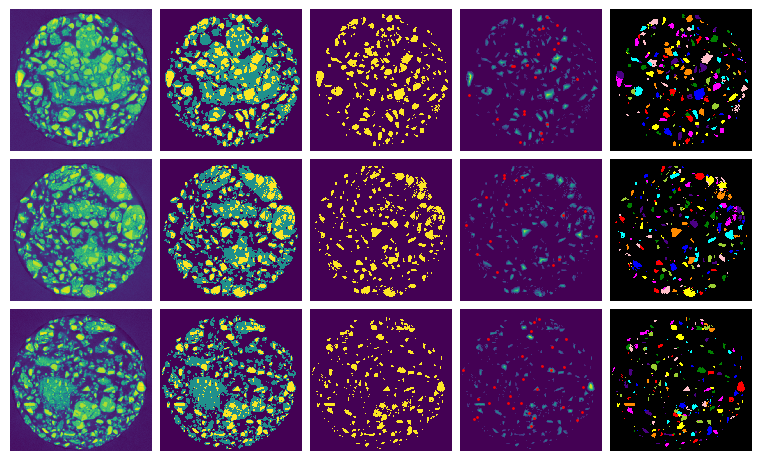

In [10]:
fig, axes = sf.plot_segment_steps(
    imgs_med, imgs_thresh, imgs_binarized, segment_dict, slices=slices
)
plt.show()

Plotting images: [100, 450, 800]


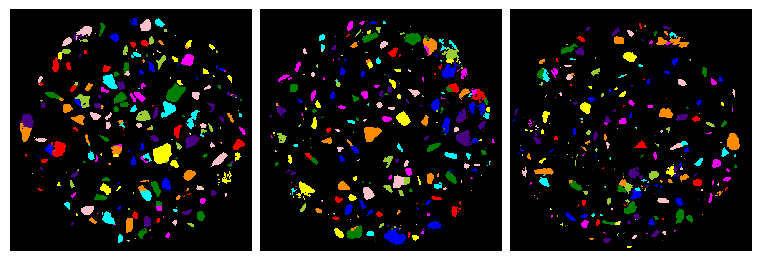

In [11]:
imgs = None
imgs_filtered = None
imgs_filtered_bw = None
imgs_seg_color = color.label2rgb(segment_dict['integer-labels'], bg_label=0)
fig, axes = sf.plot_imgs(
    imgs_seg_color,
    slices=slices,
    fig_w=7.5,
    dpi=100
)

## Add binder to labeled segmentation

In [12]:
# Create new array that will represent labeled particles and binder
imgs_seg_binder = segment_dict['integer-labels'].copy()
# Replace any pixels with value 1 with an unused value so included as binder
imgs_seg_binder[imgs_seg_binder == 1] = imgs_seg_binder.max() + 1
# Set locations where binder exist (igms_thresh == 1) to 1 in new array
imgs_seg_binder[imgs_thresh == 1] = 1

Plotting images: [100, 450, 800]


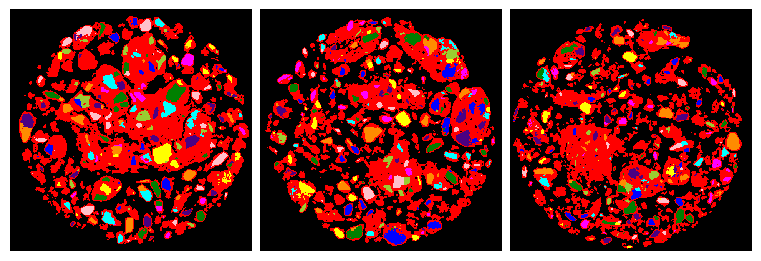

In [13]:
segment_dict = None
imgs_seg_color = None
imgs_seg_binder_color = color.label2rgb(imgs_seg_binder, bg_label=0)
fig, axes = sf.plot_imgs(
    imgs_seg_binder_color,
    slices=slices,
    fig_w=7.5,
    dpi=100
)

## Save labeled particles & binder

In [14]:
save_dir_path = Path(r'..\data\IDOX_EstaneNP\IDOX_EstaneNP_AHE_labeled')
sf.save_images(imgs_seg_binder, save_dir_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '..\\data\\IDOX_EstaneNP\\IDOX_EstaneNP_AHE_labeled'